# 6. 몬테카를로 오프-폴리시 제어 (Off-policy MC Control)

강화학습에는 **온-폴리시(On-policy)**와 **오프-폴리시(Off-policy)** 두 가지 주요 학습 방식이 있다.

* **On-policy:** "나(학습하는 정책)"의 행동으로 경험을 쌓고, 그것으로 "나"를 학습시킨다. (예: -Greedy로 움직이고 -Greedy를 개선)
* **Off-policy:** "다른 녀석(행동 정책)"이 쌓은 경험을 보고, "나(목표 정책)"를 학습시킨다.

이번 챕터에서는 **중요도 샘플링(Importance Sampling)** 기법을 사용하여, 에이전트가 무작위로 탐험하며 얻은 데이터를 이용해 최적의 정책(탐욕적 정책)을 학습하는 과정을 실습한다.

### 0. 라이브러리 및 환경 설정

기존과 동일하게 `gymnasium`을 사용하며 미로 환경을 구성한다.

In [25]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces
from IPython import display

# Jupyter Notebook 내 시각화 설정
%matplotlib inline

In [26]:
# ---------------------------------------------------------
# 1. 커스텀 Maze 환경 정의 (Gymnasium 기반)
# ---------------------------------------------------------
class Maze(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = spaces.MultiDiscrete([5, 5]) # 5x5 그리드
        self.action_space = spaces.Discrete(4) # 0:Up, 1:Right, 2:Down, 3:Left
        self.state = np.array([0, 0])
        self.target = np.array([4, 4])
        self.render_mode = 'rgb_array'

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.array([0, 0])
        return self.state, {}

    def step(self, action):
        moves = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
        move = moves[action]
        next_state = np.clip(self.state + np.array(move), 0, 4)
        self.state = next_state

        terminated = np.array_equal(self.state, self.target)
        reward = -1.0
        if terminated:
            reward = 0.0

        return self.state, reward, terminated, False, {}

    def render(self):
        grid = np.zeros((5, 5, 3), dtype=np.uint8) + 255
        grid[self.state[0], self.state[1]] = [0, 0, 255]
        grid[self.target[0], self.target[1]] = [0, 255, 0]
        return np.kron(grid, np.ones((40, 40, 1), dtype=np.uint8))

# 시각화 헬퍼 함수
def plot_action_values(action_values):
    values = np.max(action_values, axis=2)
    plt.figure(figsize=(6, 6))
    plt.imshow(values, cmap='coolwarm', interpolation='none')
    for r in range(5):
        for c in range(5):
            plt.text(c, r, f"{values[r, c]:.1f}", ha='center', va='center', color='black')
    plt.colorbar(label='Max Q-value')
    plt.title("Action Value Table (Max Q)")
    plt.show()

def plot_policy(target_policy):
    # Target Policy는 Deterministic(결정적)하므로 바로 argmax 사용
    plt.figure(figsize=(6, 6))
    plt.imshow(np.zeros((5, 5)), cmap='gray', vmin=0, vmax=1)
    arrows = {0: (0, -0.3), 1: (0.3, 0), 2: (0, 0.3), 3: (-0.3, 0)}
    for r in range(5):
        for c in range(5):
            if r == 4 and c == 4: continue
            # target_policy[r, c]는 확률 분포가 아니라 행동 인덱스 자체를 저장한다고 가정
            action = target_policy[r, c]
            dx, dy = arrows[action]
            plt.arrow(c, r, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')
    plt.grid(color='white')
    plt.title("Optimal Target Policy")
    plt.show()

---

## 1. 이론: 중요도 샘플링 (Importance Sampling)

오프-폴리시 학습에서는 두 가지 정책이 존재한다.

1. **목표 정책(Target Policy, ):** 우리가 학습시키고자 하는 최적 정책. 보통 탐욕적(Greedy)이다.
2. **행동 정책(Behavior Policy, ):** 에피소드를 생성하기 위해 실제로 움직이는 정책. 다양한 경험을 위해 무작위성을 가진다.

행동 정책 로 얻은 보상들을 가지고 목표 정책 의 가치를 추정하려면, 두 정책 간의 확률 비율인 **중요도 비율(Importance Sampling Ratio, )**을 곱해주어야 한다.

또한, 단순 평균 대신 **가중 중요도 샘플링(Weighted Importance Sampling)**을 사용하여 분산이 커지는 문제를 방지한다. 값 업데이트 식은 다음과 같다.

여기서 $C(s,a)$는 중요도 가중치 의 누적 합이다.

---

## 2. 초기화

환경과 변수들을 초기화한다.

* `Q(s, a)`: 행동 가치 함수.
* `C(s, a)`: 가중치 의 누적 합을 저장할 테이블. 0으로 초기화한다.
* `target_policy`: 각 상태에서 최적의 행동 인덱스를 저장한다.

In [27]:
env = Maze()

# Q-테이블 초기화
action_values = np.zeros(shape=(5, 5, 4))
# 최적 정책 (초기에는 모두 0번 행동)
target_policy = np.zeros(shape=(5, 5), dtype=int)
# 누적 가중치 C 테이블
cumulative_weights = np.zeros(shape=(5, 5, 4))

print("초기화 완료")

초기화 완료


---

## 3. 행동 정책 정의

행동 정책 는 에이전트가 다양한 경험을 하도록 **완전 무작위(Random)** 정책을 사용하거나, 아주 부드러운 정책을 사용한다. 여기서는 구현의 편의를 위해 모든 행동을 균등한 확률(0.25)로 선택하는 정책을 사용한다.

In [28]:
def behavior_policy(state):
    # 4방향 모두 0.25의 확률 (Soft Policy)
    return np.random.randint(4)

# 행동 정책의 확률 b(a|s) = 0.25
prob_behavior = 0.25

---

## 4. 오프-폴리시 MC 제어 알고리즘 구현

이제 가중 중요도 샘플링을 이용한 MC 제어를 구현한다.

**핵심 로직:**

1. 행동 정책 로 에피소드를 끝까지 진행한다.
2. 에피소드의 뒤에서부터 역순으로 루프를 돈다.
3. 중요도 가중치 를 반영하여 와 를 업데이트한다.
4. 목표 정책 를 값에 대해 탐욕적(Greedy)으로 업데이트한다.
5. 만약 행동 정책이 수행한 행동이 목표 정책과 다르다면, 이 되어 이 되므로 루프를 중단한다.

In [29]:
def off_policy_mc_control(action_values, target_policy, cumulative_weights, episodes, gamma=0.99):
    
    for episode in range(1, episodes + 1):
        state, _ = env.reset()
        done = False
        transitions = []
        
        # 1. 행동 정책(b)을 이용하여 에피소드 생성 (완전 무작위)
        while not done:
            action = behavior_policy(tuple(state))
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            transitions.append((state, action, reward))
            state = next_state
            
        # 2. 역순으로 가치 및 정책 업데이트
        G = 0.0
        W = 1.0 # 중요도 가중치
        
        for state_t, action_t, reward_t in reversed(transitions):
            r, c = state_t
            
            G = gamma * G + reward_t
            
            # C(S, A) 업데이트
            cumulative_weights[r, c, action_t] += W
            
            # Q(S, A) 업데이트
            q_val = action_values[r, c, action_t]
            action_values[r, c, action_t] += (W / cumulative_weights[r, c, action_t]) * (G - q_val)
            
            # 목표 정책 업데이트 (Greedy)
            best_action = np.argmax(action_values[r, c])
            target_policy[r, c] = best_action
            
            # 행동 정책이 목표 정책과 다른 행동을 했다면 학습 중단 (가중치 0)
            if action_t != best_action:
                break
            
            # 중요도 가중치 갱신 (Soft policy 확률인 0.25로 나눔)
            W = W * (1.0 / prob_behavior)

    return action_values, target_policy

print("알고리즘 구현 완료")

알고리즘 구현 완료


---

## 5. 학습 실행 및 결과 확인

에이전트를 학습시킨다. 오프-폴리시 방식은 무작위로 움직이는 데이터만을 가지고도 최적의 경로(목표 정책)를 찾아낸다는 점이 강력하다.

In [33]:
# 테이블 재초기화
action_values = np.zeros(shape=(5, 5, 4)) - 100.0 # 초기값을 낮게 설정하여 탐험 유도 가능 (선택사항)
target_policy = np.zeros(shape=(5, 5), dtype=int)
cumulative_weights = np.zeros(shape=(5, 5, 4))

print("학습 시작 (30,000 에피소드)...")

# 오프 폴리시는 수렴에 더 많은 데이터가 필요할 수 있음
off_policy_mc_control(action_values, target_policy, cumulative_weights, episodes=30000)

print("학습 완료!")

학습 시작 (30,000 에피소드)...
학습 완료!


### 5.1 학습된 가치 및 정책 시각화

학습 결과, 에이전트는 무작위로 돌아다녔음에도 불구하고 목표 정책(화살표)은 최적 경로를 가리키고 있음을 확인할 수 있다.

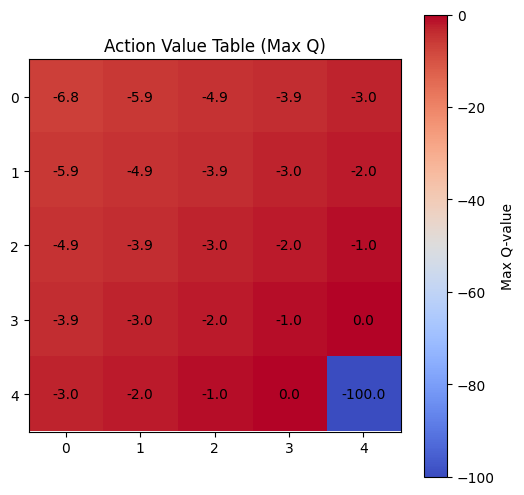

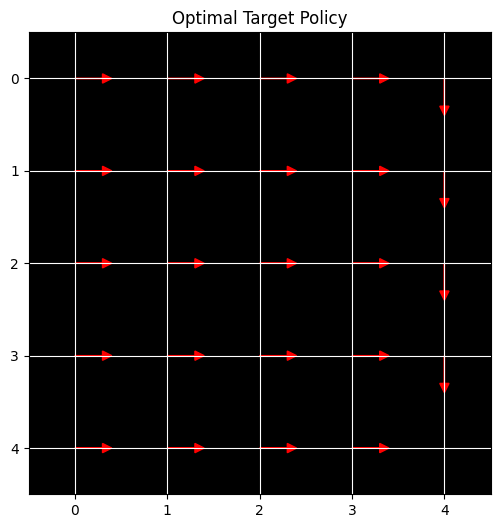

In [34]:
plot_action_values(action_values)
plot_policy(target_policy)

### 5.2 최적 정책 테스트 (Target Policy)

학습된 목표 정책(`target_policy`)을 사용하여 에이전트가 미로를 탈출하는지 확인한다. 이때는 무작위 행동 없이 오직 학습된 최적 행동만 수행한다.

테스트 종료


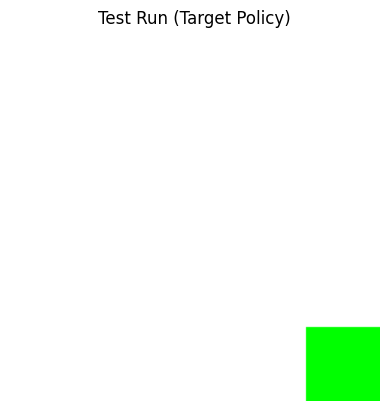

In [35]:
def test_agent(env, policy_table):
    state, _ = env.reset()
    done = False
    step = 0
    img = plt.imshow(env.render())
    plt.axis('off')
    plt.title("Test Run (Target Policy)")

    while not done and step < 20:
        # 정책 테이블에서 행동 조회
        r, c = state
        action = policy_table[r, c]

        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        step += 1
    print("테스트 종료")

test_agent(env, target_policy)

### 요약

오프-폴리시 몬테카를로 제어는 **탐험(Exploration)**을 담당하는 행동 정책과 **최적화(Optimization)**를 담당하는 목표 정책을 분리함으로써, 지속적인 탐험을 하면서도 최적 정책을 학습할 수 있게 해준다. 이때 두 정책의 분포 차이를 보정하기 위해 **중요도 샘플링(Importance Sampling)**을 사용한다는 점이 핵심이다.